In [1]:
import pandas as pd
import numpy as np
import pathlib
import pickle
import torch as t
import sys
import matplotlib.pyplot as plt
sys.path.append('C:\\Users\\keren\\Projects\\pytorch-sgns')
import ai2v_model

import numpy as np
from sklearn.manifold import TSNE

In [12]:
H_FOLD = 'C:/Users/keren/Projects/pytorch-sgns'
DATASET = 'movielens'

DATA_FOLD = f'corpus/{DATASET}_llo'

AI2V_OUT_FOLD = f'output/{DATASET}_ai2v_llo'
I2V_OUT_FOLD = f'output/{DATASET}_i2v_llo'
BPR_OUT_FOLD = f'output/{DATASET}_bpr_llo'
LGCN_OUT_FOLD = f'output/{DATASET}_lightgcn_llo'
NCF_OUT_FOLD = f'output/{DATASET}_ncf_llo'

AI2V_MODEL_FILE = f'{H_FOLD}/{AI2V_OUT_FOLD}/model.pt'
I2V_MODEL_FILE = f'{H_FOLD}/{I2V_OUT_FOLD}/model.pt'

## Performance on cold start items

In [3]:
ic = pickle.load(pathlib.Path(f'{H_FOLD}/{DATA_FOLD}', 'ic.dat').open('rb'))
idx2item = pickle.load(pathlib.Path(f'{H_FOLD}/{DATA_FOLD}', 'idx2item.dat').open('rb'))

In [55]:
k = 20
metric = 'hr'

In [56]:
# AI2V_MET_FILE = f'{H_FOLD}/{AI2V_OUT_FOLD}/ai2v_netflix_{k}_{metric}.csv'
# I2V_MET_FILE = f'{H_FOLD}/{I2V_OUT_FOLD}/i2v_netflix_{k}_{metric}.csv'

In [57]:
AI2V_MET_FILE = f'{H_FOLD}/{AI2V_OUT_FOLD}/{metric}_{k}.csv'
I2V_MET_FILE = f'{H_FOLD}/{I2V_OUT_FOLD}/{metric}_{k}.csv'

In [58]:
met_col_i2v = f'{metric}_i2v'
met_col_ai2v = f'{metric}_ai2v'

df_i2v = pd.read_csv(I2V_MET_FILE, names=['u_id','i_id',met_col_i2v])
df_ai2v = pd.read_csv(AI2V_MET_FILE, names=['u_id','i_id',met_col_ai2v])

df_i2v['i_name'] = np.array(idx2item)[df_i2v['i_id'].tolist()]
df_ai2v['i_name'] = np.array(idx2item)[df_ai2v['i_id'].tolist()]

df_i2v['item_cnt'] = df_i2v['i_name'].map(ic)
df_ai2v['item_cnt'] = df_ai2v['i_name'].map(ic)

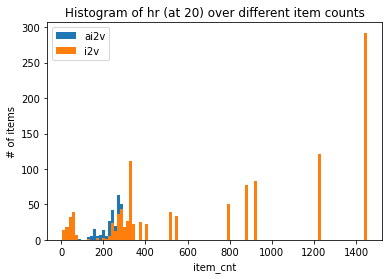

In [59]:
plt.hist(df_ai2v[df_ai2v[met_col_ai2v]==1]['item_cnt'], bins=100, label='ai2v')
plt.hist(df_i2v[df_i2v[met_col_i2v]==1]['item_cnt'], bins=100, label='i2v')
plt.xlabel('item_cnt')
plt.ylabel('# of items')
plt.title(f'Histogram of {metric} (at {k}) over different item counts')
plt.legend()
plt.show()

# TSNE

In [114]:
yahoo = pickle.load(open(f'{H_FOLD}/data/100_songs_train.pkl','rb'))

In [115]:
idx2item = pickle.load(pathlib.Path(f'{H_FOLD}/{DATA_FOLD}', 'idx2item.dat').open('rb'))

In [116]:
idx2item_dict = {i:k for i,k in enumerate(idx2item)}

In [117]:
itemid2singer = {yahoo[1][k]: k.split('#')[1] for k in yahoo[1].keys()}

In [119]:
idx2singer = {k: itemid2singer[int(idx2item_dict[k])] for k in list(idx2item_dict.keys())[:-2]}

In [130]:
colors = {singer:i for i,singer in enumerate(list(set(list(idx2singer.values()))))}

In [145]:
colors

{'Bob_Marley_&_The_Wailers': 0,
 'Toby_Keith': 1,
 'Metallica': 2,
 'Kenny_Chesney': 3,
 'Brad_Paisley': 4}

In [79]:
# Read MovieLens Movies
# datContent = [i.strip().split() for i in open(f'{H_FOLD}/data/movies.dat').readlines()]
# movs_jsons = []
# for mov_t in datContent:
#     mov = mov_t[:-1]
#     m_id, m_name_1 = mov[0].split('::')
#     tag = mov_t[-1]
#     t_id, t_name = tag.split('::')
#     movs_jsons.append({'id': m_id ,'name': m_name_1 + ' ' + ' '.join(mov[1:]), 'tag_id': t_id,  'tag name': t_name})

In [80]:
model = t.load(MODEL_FILE,map_location=t.device('cpu'))

In [81]:
X_embedded = TSNE(n_components=2).fit_transform(np.array(model.ai2v.tvectors.weight.data))

In [144]:
labels = np.array([colors[singer] for singer in idx2singer.values()])

No handles with labels found to put in legend.


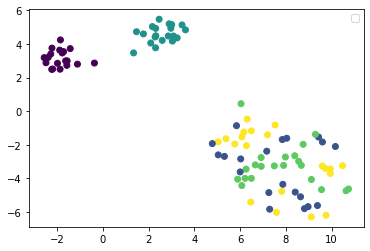

In [153]:
# fig, ax = plt.subplots()
# for clr in colors.values():
#     ix = np.where(labels==clr)
#     print(ix)
#     print(clr)
#     ax.scatter(X_embedded[ix,0], X_embedded[ix, 1], c = clr, s = 100)
# ax.legend()
# plt.show()

plt.scatter(X_embedded[:-2,0],X_embedded[:-2,1], c=[colors[singer] for singer in idx2singer.values()])
plt.legend()

# Popular Items Removal

In [4]:
k = 20
ic_file = f'{H_FOLD}/{DATA_FOLD}/full_ic.dat'
item2idx_file = f'{H_FOLD}/{DATA_FOLD}/full_item2idx.dat'

In [5]:
item_cnts = pickle.load(open(ic_file, 'rb'))
itm_cnts_df = pd.DataFrame([item_cnts.keys(), item_cnts.values()]).T
itm_cnts_df.columns=['item_id','cnt']

In [6]:
# create hits file of popularity model

test_file = f'{H_FOLD}/{DATA_FOLD}/test_raw.csv'
test = pd.read_csv(test_file, names=['user','item'])
itms_pop_rank = [int(itm) for itm in itm_cnts_df.sort_values(by='cnt', ascending=False)['item_id'].tolist()[:k]]

hits = 0

test['pred_loc'] = 0
test['hit'] = test.apply(lambda row: 1 if row['item'] in itms_pop_rank else 0 , axis=1)
test.to_csv(f'{H_FOLD}/output/pop_model_hr_{k}.csv', index=False)

In [7]:
cnts_sorted = itm_cnts_df.sort_values(by=['cnt'],ascending=False)['cnt'].tolist()

In [8]:
items_sorted = [int(item) for item in itm_cnts_df.sort_values(by=['cnt'],ascending=False)['item_id'].tolist()[:-2]]

In [9]:
binned_items = [items_sorted[:i+10] for i in range(0, len(items_sorted), 10)]

In [10]:
binned_items.insert(0, [])

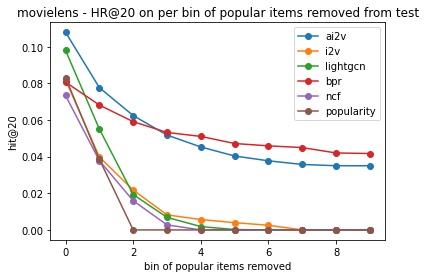

In [13]:
number_of_bins = 10
for hits_file, label in zip([f'{H_FOLD}/{AI2V_OUT_FOLD}/hr_{k}.csv', 
                             f'{H_FOLD}/{I2V_OUT_FOLD}/hr_{k}.csv', 
                             f'{H_FOLD}/{LGCN_OUT_FOLD}/hr_{k}.csv',
                             f'{H_FOLD}/{BPR_OUT_FOLD}/hr_{k}.csv',
                             f'{H_FOLD}/{NCF_OUT_FOLD}/hr_{k}.csv',
                             f'{H_FOLD}/output/pop_model_hr_{k}.csv'],
                            ['ai2v','i2v','lightgcn','bpr','ncf','popularity']):
    hits = pd.read_csv(hits_file, usecols=[0,1,2,3], skiprows=1, names=['user','item','pred_loc','hit'])
    hit_ratios = []
    for bin_ in binned_items[:number_of_bins]:
        new_test = hits[~hits['item'].isin(bin_)]
        if not new_test.empty:
            hit_ratios.append(new_test[new_test['hit']==1].shape[0] / new_test.shape[0])
        else:
            hit_ratios.append(0)
    plt.plot([i for i in list(range(number_of_bins))], hit_ratios,'-o', label=label)
plt.xlabel('bin of popular items removed')
plt.ylabel(f'hit@{k}')
plt.title(f'{DATASET} - HR@{k} on per bin of popular items removed from test')
plt.legend()

# Statistics

# Attention Scores

### MovieLens

In [ ]:
DATASET = 'movielens'

DATA_FOLD = f'corpus/{DATASET}_llo' #######################

AI2V_OUT_FOLD = f'output/{DATASET}_ai2v_llo' ########################

AI2V_MODEL_FILE = f'{H_FOLD}/{AI2V_OUT_FOLD}/model.pt'

k = 20 #############################
ic_file = f'{DATA_FOLD}/full_ic.dat'
item2idx_file = f'{DATA_FOLD}/full_item2idx.dat'

hits_ai2v = pd.read_csv(f'{AI2V_OUT_FOLD}/hr_{k}.csv', usecols=[0,1,2,3], skiprows=1, names=['user','item','pred_loc','hit'])
hits_ai2v[hits_ai2v['hit']==1].head(100)

In [ ]:
# from dat to csv:
file_out = './corpus/movielens_llo/movies.csv'
with open(file_out, 'w', newline='', encoding="utf-8") as w_file:
    writer = csv.writer(w_file, delimiter=',', quotechar='"', escapechar='\n', quoting=csv.QUOTE_NONE)
    writer.writerow(['id', 'name', 'genres'])
    with open(f'{DATA_FOLD}/movies.dat', encoding='ISO-8859-1') as data:
        for line in data:
            line = line.split('::')
            item_idx = line[0]
            item_name = line[1]
            item_genres = line[2]
            writer.writerow([str(item_idx), str(item_name), str(item_genres)])

test_data = pickle.load(open(f'{DATA_FOLD}/test.dat','rb'))
item2idx = pickle.load(open(f'{DATA_FOLD}/item2idx.dat','rb'))
idx2item = {v:k for k,v in item2idx.items()}
test_orig = []
for tup in test_data:
    target = int(idx2item[tup[1]])
    context = [int(idx2item[idx]) for idx in tup[0]]
    test_orig.append((context, target))
movies = pd.read_csv(f'{DATA_FOLD}/movies.csv')
movies_test = []
print(movies)
for tup in test_orig:
    target = movies.loc[movies['id']==tup[1],'name'].values[0]
    context = [movies.loc[movies['id']==idx,'name'].values[0] 
              for idx in tup[0]]
    movies_test.append((context, target))

In [ ]:
attention_score = pickle.load(open(f'{AI2V_OUT_FOLD}/attention_scores.pkl','rb'))

lists = []
for idx in range(len(attention_score[:100])):
    if len(attention_score[idx]) <= 20:
        lists.append(idx)
print(lists)

In [ ]:
sample = 53
data = np.expand_dims(attention_score[sample], axis=0)
labels = movies_test[sample][0]
target = movies_test[sample][1]


cmap = plt.cm.summer
norm = plt.Normalize(data.min(), data.max())
rgba = cmap(norm(data))

fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(rgba, interpolation='nearest')

im = ax.imshow(data, visible=False, cmap=cmap)

ax.set_xticks(list(range(data.shape[1])))

ax.set_xticklabels(labels, rotation = 90)

for i in range(data.shape[1]):
    text = ax.text(i, 0, round(data[0, i],3),
                       ha="center", va="center")

fig.colorbar(im)
plt.title(f'Attention scores for {target}')
plt.show()

sample = 5
# For the movie "Pretty Woman" the movie that received the higher score is "my Fair Lady". Both movies describes the journey that the woman goes through from the streets to a lady accepted by society. Both movies are known and successful romances.

sample = 19
# For the movie "The Fifth Element" the movie that received the higher score is "Matrix". Both movies are science fiction movies. The rest of the movies on the list are dramas and so "Matrix" is the best fit for "The Fifth Element".

sample = 31
# For the movie "The Green Mile" the movie that received the higher score is "Twelve Monkeys". "The Green Mile" is a fantasy drama movie and "Twelve Monkeys" is a science fiction drama movie. In both movies, there is an engagement with a disease.

sample = 45
# For the movie "Evil Dead 2" the movie that received the higher score is "I Still Know What You Did Last Summer". Both movies are horror movies and sequels. Most of the movies on this list are horror movies when evil dead 2 is a horror-comedy.

sample = 49

sample = 82
# For the movie "Bone Collector" the movie that received the higher score is "The Exorcist". "Bone Collector" is a thriller and "The Exorcist" is a horror movie and those are two genres that have a lot of similarities. The second best movie is "Final Destination" which is also a horror movie.

In [ ]:
# Not working right, show the same scores every time.
data = np.expand_dims(attention_score[0], axis=1)
labels = movies_test[0][0]
target = movies_test[15][1]
cmap = plt.cm.gray
norm = plt.Normalize(data.min(), data.max())
rgba = cmap(norm(data))
fig, ax = plt.subplots(figsize=(2, 10))
ax.imshow(rgba, interpolation='nearest')
im = ax.imshow(data, visible=False, cmap=cmap)
ax.set_yticks(list(range(data.shape[0])))
ax.set_yticklabels(labels)
fig.colorbar(im)
plt.title(f'Attention scores for {target}')

### GoodBooks

In [ ]:
DATASET = 'goodbooks'

DATA_FOLD = f'corpus/{DATASET}_llo' #######################

AI2V_OUT_FOLD = f'output/{DATASET}_ai2v_llo' ########################

AI2V_MODEL_FILE = f'{H_FOLD}/{AI2V_OUT_FOLD}/model.pt'

k = 20 #############################
ic_file = f'{DATA_FOLD}/full_ic.dat'
item2idx_file = f'{DATA_FOLD}/full_item2idx.dat'

hits_ai2v = pd.read_csv(f'{AI2V_OUT_FOLD}/hr_{k}.csv', usecols=[0,1,2,3], skiprows=1, names=['user','item','pred_loc','hit'])
hits_ai2v[hits_ai2v['hit']==1].head(100)

In [ ]:
test_data = pickle.load(open(f'{DATA_FOLD}/test.dat','rb'))
item2idx = pickle.load(open(f'{DATA_FOLD}/item2idx.dat','rb'))
idx2item = {v:k for k,v in item2idx.items()}
test_orig = []
for tup in test_data:
    target = int(idx2item[tup[1]])
    context = [int(idx2item[idx]) for idx in tup[0]]
    test_orig.append((context, target))
movies = pd.read_csv(f'{DATA_FOLD}/books_job.csv', encoding='latin-1')
movies_test = []
for tup in test_orig:
    target = movies.loc[movies['id']==tup[1],'name'].values[0]
    context = [movies.loc[movies['id']==idx,'name'].values[0] 
              for idx in tup[0]]
    movies_test.append((context, target))

In [ ]:
attention_score = pickle.load(open(f'{AI2V_OUT_FOLD}/attention_scores.pkl','rb'))

lists = []
for idx in range(len(attention_score[:100])):
    if len(attention_score[idx]) <= 20:
        lists.append(idx)
print(lists)

In [ ]:
sample = 0
data = np.expand_dims(attention_score[sample], axis=0)
labels = movies_test[sample][0]
target = movies_test[sample][1]


cmap = plt.cm.summer
norm = plt.Normalize(data.min(), data.max())
rgba = cmap(norm(data))

fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(rgba, interpolation='nearest')

im = ax.imshow(data, visible=False, cmap=cmap)

ax.set_xticks(list(range(data.shape[1])))

ax.set_xticklabels(labels, rotation = 90)

for i in range(data.shape[1]):
    text = ax.text(i, 0, round(data[0, i],3),
                       ha="center", va="center")

fig.colorbar(im)
plt.title(f'Attention scores for {target}')
plt.show()

sample = 46

sample = 70

sample = 97

sample = 98

### Netflix

In [ ]:
DATASET = 'netflix'

DATA_FOLD = f'corpus/{DATASET}_llo' #######################

AI2V_OUT_FOLD = f'output/{DATASET}_ai2v_llo' ########################

AI2V_MODEL_FILE = f'{H_FOLD}/{AI2V_OUT_FOLD}/model.pt'

k = 20 #############################
ic_file = f'{DATA_FOLD}/full_ic.dat'
item2idx_file = f'{DATA_FOLD}/full_item2idx.dat'

hits_ai2v = pd.read_csv(f'{AI2V_OUT_FOLD}/hr_{k}.csv', usecols=[0,1,2,3], skiprows=1, names=['user','item','pred_loc','hit'])
hits_ai2v[hits_ai2v['hit']==1].head(100)

In [ ]:
# Theres a problem, it's not working.
test_data = pickle.load(open(f'{DATA_FOLD}/test.dat','rb'))
item2idx = pickle.load(open(f'{DATA_FOLD}/item2idx.dat','rb'))
idx2item = {v:k for k,v in item2idx.items()}
test_orig = []
for tup in test_data:
    target = int(idx2item[tup[1]])
    context = [int(idx2item[idx]) for idx in tup[0]]
    test_orig.append((context, target))
movies = pd.read_csv(f'{DATA_FOLD}/movie_titles.csv', encoding='latin-1')
movies_test = []
print(movies)
for tup in test_orig:
    print(movies.loc[movies['id']==tup[1],'name'])
    print(tup[1])
    print(tup)
    target = movies.loc[movies['id']==tup[1],'name'].values[0]
    context = [movies.loc[movies['id']==idx,'name'].values[0] 
              for idx in tup[0]]
    movies_test.append((context, target))

In [ ]:
attention_score = pickle.load(open(f'{AI2V_OUT_FOLD}/attention_scores.pkl','rb'))

lists = []
for idx in range(len(attention_score[:100])):
    if len(attention_score[idx]) <= 20:
        lists.append(idx)
print(lists)

In [ ]:
sample = 0
data = np.expand_dims(attention_score[sample], axis=0)
labels = movies_test[sample][0]
target = movies_test[sample][1]


cmap = plt.cm.summer
norm = plt.Normalize(data.min(), data.max())
rgba = cmap(norm(data))

fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(rgba, interpolation='nearest')

im = ax.imshow(data, visible=False, cmap=cmap)

ax.set_xticks(list(range(data.shape[1])))

ax.set_xticklabels(labels, rotation = 90)

for i in range(data.shape[1]):
    text = ax.text(i, 0, round(data[0, i],3),
                       ha="center", va="center")

fig.colorbar(im)
plt.title(f'Attention scores for {target}')
plt.show()

### Moviesdat

In [ ]:
DATASET = 'moviesdat'

DATA_FOLD = f'corpus/{DATASET}_llo' #######################

AI2V_OUT_FOLD = f'output/{DATASET}_ai2v_llo' ########################

AI2V_MODEL_FILE = f'{H_FOLD}/{AI2V_OUT_FOLD}/model.pt'

k = 20 #############################
ic_file = f'{DATA_FOLD}/full_ic.dat'
item2idx_file = f'{DATA_FOLD}/full_item2idx.dat'

hits_ai2v = pd.read_csv(f'{AI2V_OUT_FOLD}/hr_{k}.csv', usecols=[0,1,2,3], skiprows=1, names=['user','item','pred_loc','hit'])
hits_ai2v[hits_ai2v['hit']==1].head(100)

In [ ]:
# Theres a problem, it's not working.
test_data = pickle.load(open(f'{DATA_FOLD}/test.dat','rb'))
item2idx = pickle.load(open(f'{DATA_FOLD}/item2idx.dat','rb'))
idx2item = {v:k for k,v in item2idx.items()}
test_orig = []
for tup in test_data:
    target = int(idx2item[tup[1]])
    context = [int(idx2item[idx]) for idx in tup[0]]
    test_orig.append((context, target))
movies = pd.read_csv(f'{DATA_FOLD}/movies_job.csv', encoding='latin-1')
movies_test = []
print(movies)
for tup in test_orig:
    print(movies.loc[movies['id']==tup[1],'name'])
    print(tup[1])
    target = movies.loc[movies['id']==tup[1],'name'].values[0]
    context = [movies.loc[movies['id']==idx,'name'].values[0] 
              for idx in tup[0]]
    movies_test.append((context, target))

In [ ]:
attention_score = pickle.load(open(f'{AI2V_OUT_FOLD}/attention_scores.pkl','rb'))

lists = []
for idx in range(len(attention_score[:100])):
    if len(attention_score[idx]) <= 20:
        lists.append(idx)
print(lists)

In [ ]:
sample = 0
data = np.expand_dims(attention_score[sample], axis=0)
labels = movies_test[sample][0]
target = movies_test[sample][1]


cmap = plt.cm.summer
norm = plt.Normalize(data.min(), data.max())
rgba = cmap(norm(data))

fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(rgba, interpolation='nearest')

im = ax.imshow(data, visible=False, cmap=cmap)

ax.set_xticks(list(range(data.shape[1])))

ax.set_xticklabels(labels, rotation = 90)

for i in range(data.shape[1]):
    text = ax.text(i, 0, round(data[0, i],3),
                       ha="center", va="center")

fig.colorbar(im)
plt.title(f'Attention scores for {target}')
plt.show()